*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  01.07.2024

--- 

# Emission gridding

<!--Notebook description and usage information-->
This notebook is used to convert line source emissions into a gridded inventory.


In [1]:
import sys
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../utils')
import data_paths
from gridding import GriddingEngine

# Notebook settings

In [2]:
# select year of interest and define filenames for linesource emissions
year_of_interest = '2022'
em_cold_filename = f'linesource_munich_{year_of_interest}_cold.gpkg'
em_hot_filename = f'linesource_Munich_{year_of_interest}_new_vc.gpkg'

# define grid for gridding
grid_file = data_paths.TNO_100M_GRID
#grid_file = data_paths.TNO_1km_GRID

# select components and vehicle classes to be considered
vehicle_classes_hot = ['PC', 'MOT', 'HGV', 'LCV', 'BUS']
vehicle_classes_cold = ['PC', 'LCV']

components = ['CO', 'NOx', 'PM', 'CO2(rep)', 'CO2(total)', 
                  'NO2', 'CH4', 'BC (exhaust)', 'CO2e']

# safe result in gepackage
safe_result = False
result_filename = f'GNFR_F_{year_of_interest}_new_vc.gpkg'

## Import data

In [3]:
inventory_path = data_paths.INVENTORY_FOLDER_PATH
em_cold = gpd.read_file(inventory_path + em_cold_filename)
em_hot = gpd.read_file(inventory_path + em_hot_filename)

# import grid
tno_grid = gpd.read_file(grid_file)

## Grid inventory and combine results

In [4]:
gridding_obj = GriddingEngine(input_grid=tno_grid, crs = em_hot.crs) # hot and cold inventory have the same crs

em_hot_columns = [f'{v}_{c}' for v in vehicle_classes_hot for c in components]
em_cold_columns = [f'{v}_{c}' for v in vehicle_classes_cold for c in components]

out_grid_hot = gridding_obj.overlay_grid(em_hot, value_columns= em_hot_columns, source_type='line_kilometer')
out_grid_cold = gridding_obj.overlay_grid(em_cold, value_columns= em_cold_columns, source_type='line_kilometer')

aggregated_result = pd.DataFrame()
for c in components: 
    hot_cols_to_sum = [f'{v}_{c}' for v in vehicle_classes_hot]
    cold_cols_to_sum = [f'{v}_{c}' for v in vehicle_classes_cold]
    aggregated_result[c] = out_grid_hot[hot_cols_to_sum].sum(axis = 1)
    aggregated_result[c] = out_grid_cold[cold_cols_to_sum].sum(axis = 1) + aggregated_result[c]
    
    # convert emissions to kg
    aggregated_result[c] = aggregated_result[c]/1000

aggregated_result['geometry'] = out_grid_hot['geometry']
aggregated_result['geometry'] = out_grid_cold['geometry']
aggregated_result = gpd.GeoDataFrame(data= aggregated_result, geometry='geometry', crs = em_hot.crs)

## Plot results

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_39742/2844009980.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap= matplotlib.cm.get_cmap('twilight_shifted'),


Total Emissions of 2022


CO                 3.192641
NOx                2.148458
PM                 0.032152
CO2(rep)        1065.164732
CO2(total)      1139.631436
NO2                0.316049
CH4                0.055371
BC (exhaust)       0.015730
CO2e            1080.200173
dtype: float64

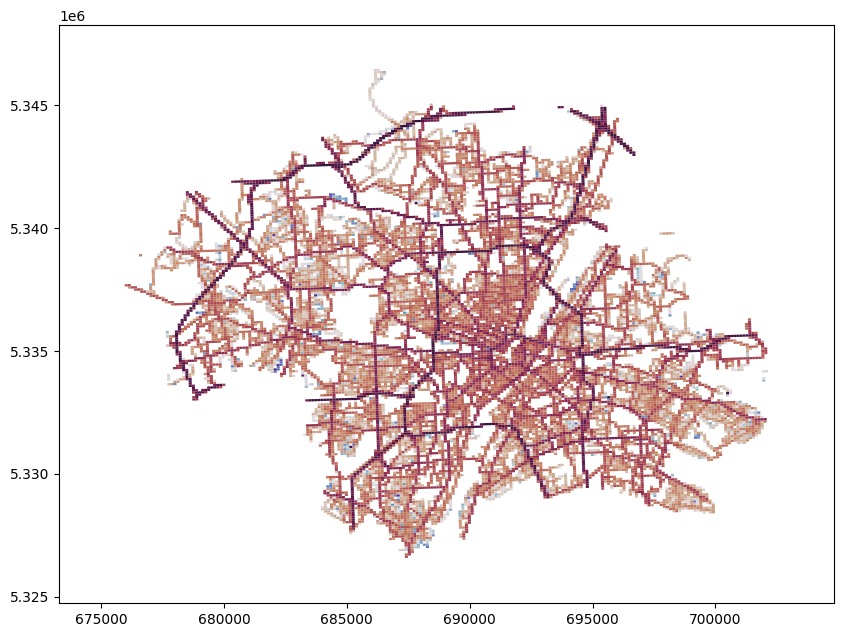

In [8]:
# plot results
fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
aggregated_result.plot(ax= ax,
                column= 'CO2(rep)',
                cmap= matplotlib.cm.get_cmap('twilight_shifted'),
                norm= matplotlib.colors.LogNorm())

print(f'Total Emissions of {year_of_interest}')
aggregated_result.sum(numeric_only=True)*1e-6

## Save results

In [6]:
if safe_result:
    path = data_paths.INVENTORY_FOLDER_PATH
    aggregated_result.to_file(path+result_filename, driver = 'GPKG')